In [ ]:
%%capture
!wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh

!bash icevision_install.sh cuda11 master
!pip install sahi<0.10

In [ ]:
!wget "https://github.com/OlafenwaMoses/FireNET/releases/download/v1.0/fire-dataset.zip"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pathlib import Path
import zipfile

from icevision.all import *
from icevision.models import *


INFO     - The mmdet config folder already exists. No need to downloaded it. Path : /root/.icevision/mmdetection_configs/mmdetection_configs-2.20.1/configs | icevision.models.mmdet.download_configs:download_mmdet_configs:17
INFO     - The mmseg config folder already exists. No need to downloaded it. Path : /root/.icevision/mmsegmentation_configs/mmsegmentation_configs-0.17.0/configs | icevision.models.mmseg.download_configs:download_mmseg_configs:19


In [ ]:
class config:
    BASE_DIR = Path('/content/drive/MyDrive/HSE')
    DATA_DIR = BASE_DIR / 'data'
    MODEL_DIR = BASE_DIR / 'models'

In [ ]:
with zipfile.ZipFile('/content/fire-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [ ]:
!rm -r dataset

In [ ]:
DS = Path('dataset')
IMG = DS / 'images'
LBL = DS / 'labels'
IMG.mkdir(parents=True, exist_ok=True)
LBL.mkdir(parents=True, exist_ok=True)

In [ ]:
!cp -a /content/fire-dataset/validation/images/. {IMG}
!cp -a /content/fire-dataset/train/images/. {IMG}
!cp -a /content/fire-dataset/validation/annotations/. {LBL}
!cp -a /content/fire-dataset/train/annotations/. {LBL}

In [ ]:
# Create the parser
parser = parsers.VOCBBoxParser(annotations_dir=LBL, images_dir=IMG)

In [ ]:
# Parse annotations to create records
train_records, valid_records = parser.parse()
parser.class_map

  0%|          | 0/502 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/502 [00:00<?, ?it/s]

<ClassMap: {'background': 0, 'fire': 1}>

In [ ]:
# Transforms
# size is set to 384 because EfficientDet requires its inputs to be divisible by 128
image_size = 384
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

In [ ]:
# Datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

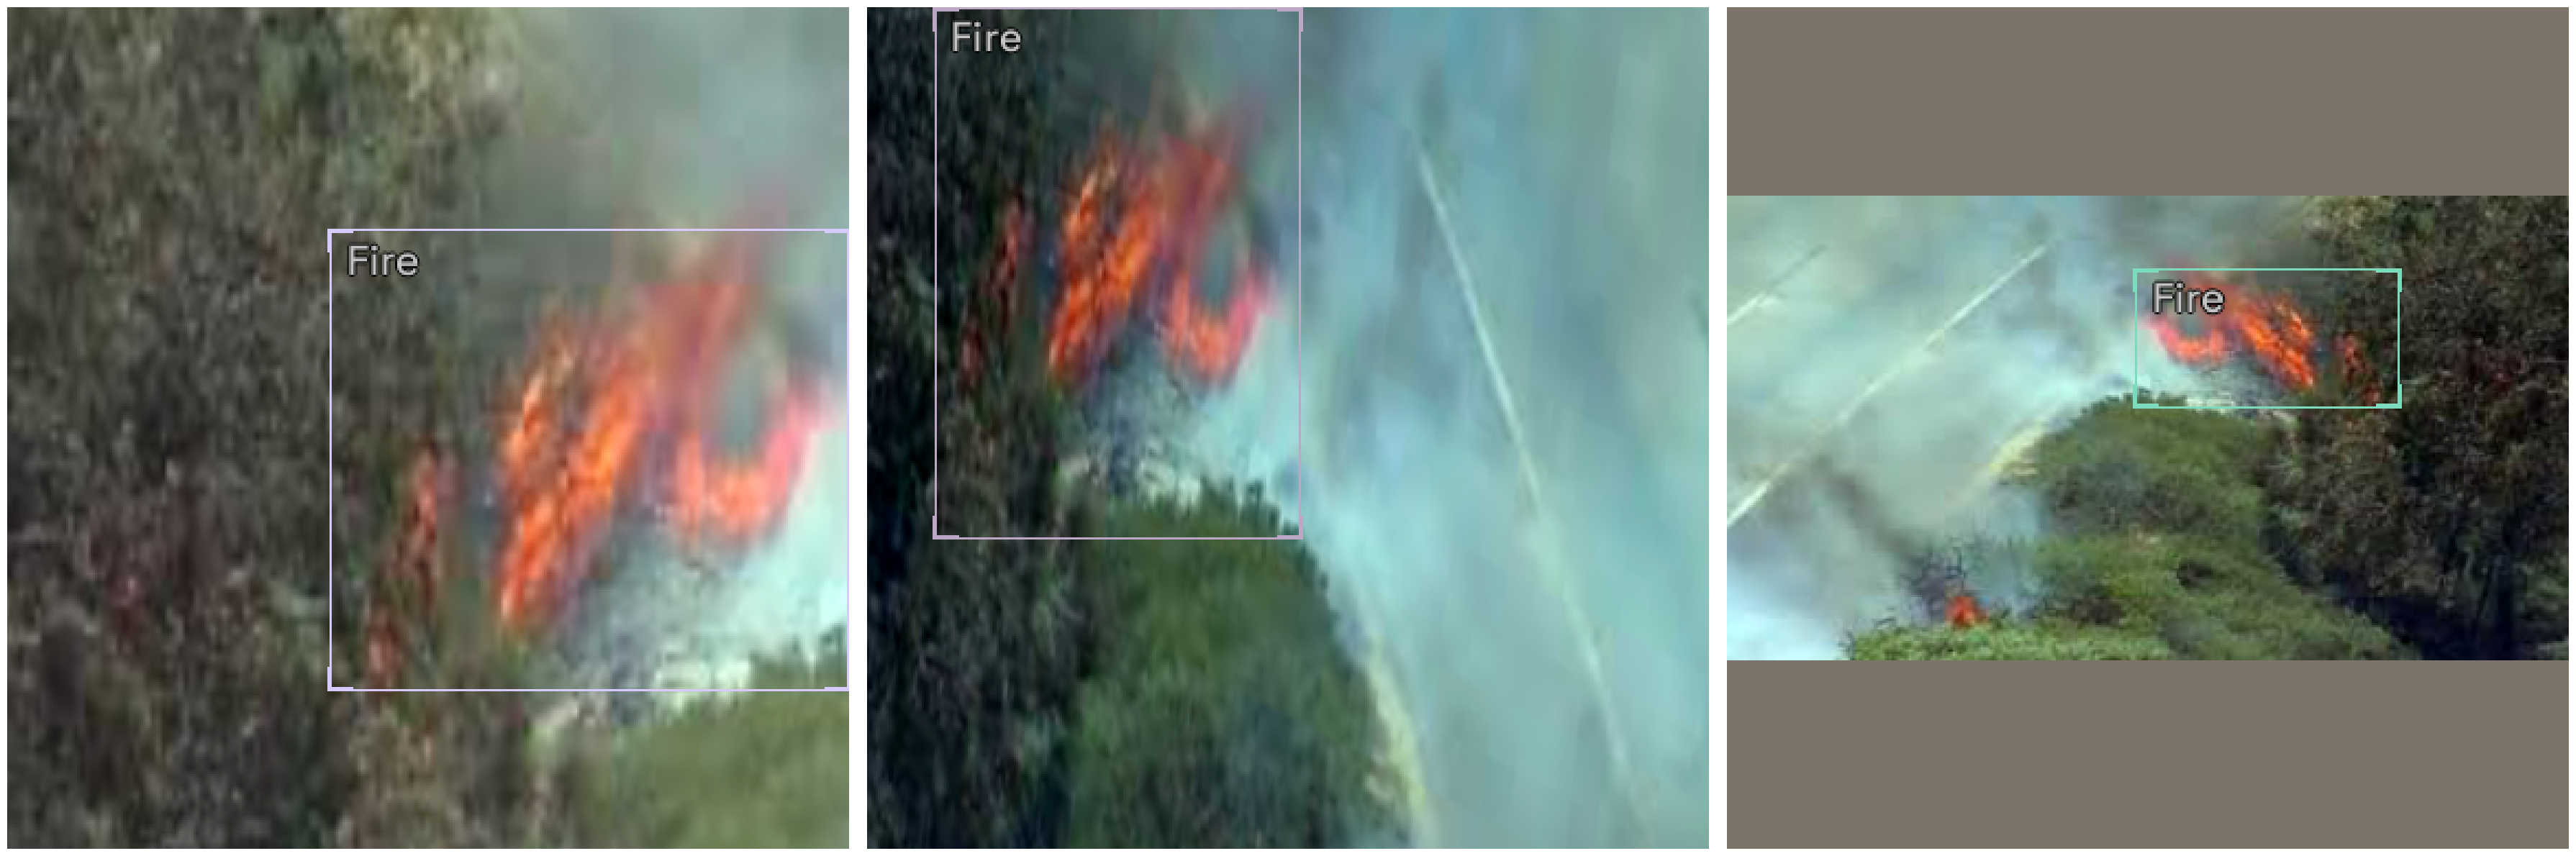

In [ ]:
# Show an element of the train_ds with augmentation transformations applied
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols=3)

In [ ]:
# Just change the value of selection to try another model

selection = 2

extra_args = {}

if selection == 2:
  model_type = models.mmdet.faster_rcnn
  backbone = model_type.backbones.resnet101_fpn_2x


model_type, backbone, extra_args

(<module 'icevision.models.mmdet.models.faster_rcnn' from '/usr/local/lib/python3.9/dist-packages/icevision/models/mmdet/models/faster_rcnn/__init__.py'>,
 {})

In [ ]:
# Instantiate the model
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map), **extra_args) 

  0%|          | 0/243518604 [00:00<?, ?B/s]

/usr/local/lib/python3.9/dist-packages/mmdet/core/anchor/builder.py:16: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  warnings.warn(
2023-04-01 09:03:28,410 - mmcv - INFO - initialize ResNet with init_cfg {'type': 'Pretrained', 'checkpoint': 'torchvision://resnet101'}
2023-04-01 09:03:28,412 - mmcv - INFO - load model from: torchvision://resnet101
2023-04-01 09:03:28,414 - mmcv - INFO - load checkpoint from torchvision path: torchvision://resnet101
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

2023-04-01 09:03:35,525 - mmcv - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2023-04-01 09:03:35,587 - mmcv - INFO - initialize FPN with init_cfg {'type': 'Xavier', 'layer': 'Conv2d', 'distribution': 'uniform'}
2023-04-01 09:03:35,633 - mmcv - INFO - initialize RPNHead with init_cfg {'type': 'Normal', 'layer': 'Conv2d', 'std': 0.01}
2023-04-01 09:03:35,645 - mmcv - INFO - initialize Shared2FCBBoxHead with init_cfg [{'type': 'Normal', 'std': 0.01, 'override': {'name': 'fc_cls'}}, {'type': 'Normal', 'std': 0.001, 'override': {'name': 'fc_reg'}}, {'type': 'Xavier', 'layer': 'Linear', 'override': [{'name': 'shared_fcs'}, {'name': 'cls_fcs'}, {'name': 'reg_fcs'}]}]
2023-04-01 09:03:35,950 - mmcv - INFO - 
backbone.conv1.weight - torch.Size([64, 3, 7, 7]): 
PretrainedInit: load from torchvision://resnet101 
 
2023-04-01 09:03:35,956 - mmcv - INFO - 
backbone.bn1.weight - torch.Size([64]): 
PretrainedInit: load from 

load checkpoint from local path: checkpoints/faster_rcnn/faster_rcnn_r101_fpn_2x_coco_bbox_mAP-0.398_20200504_210455-1d2dac9c.pth
The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([2, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([4, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([4]).


In [ ]:
# Data Loaders
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


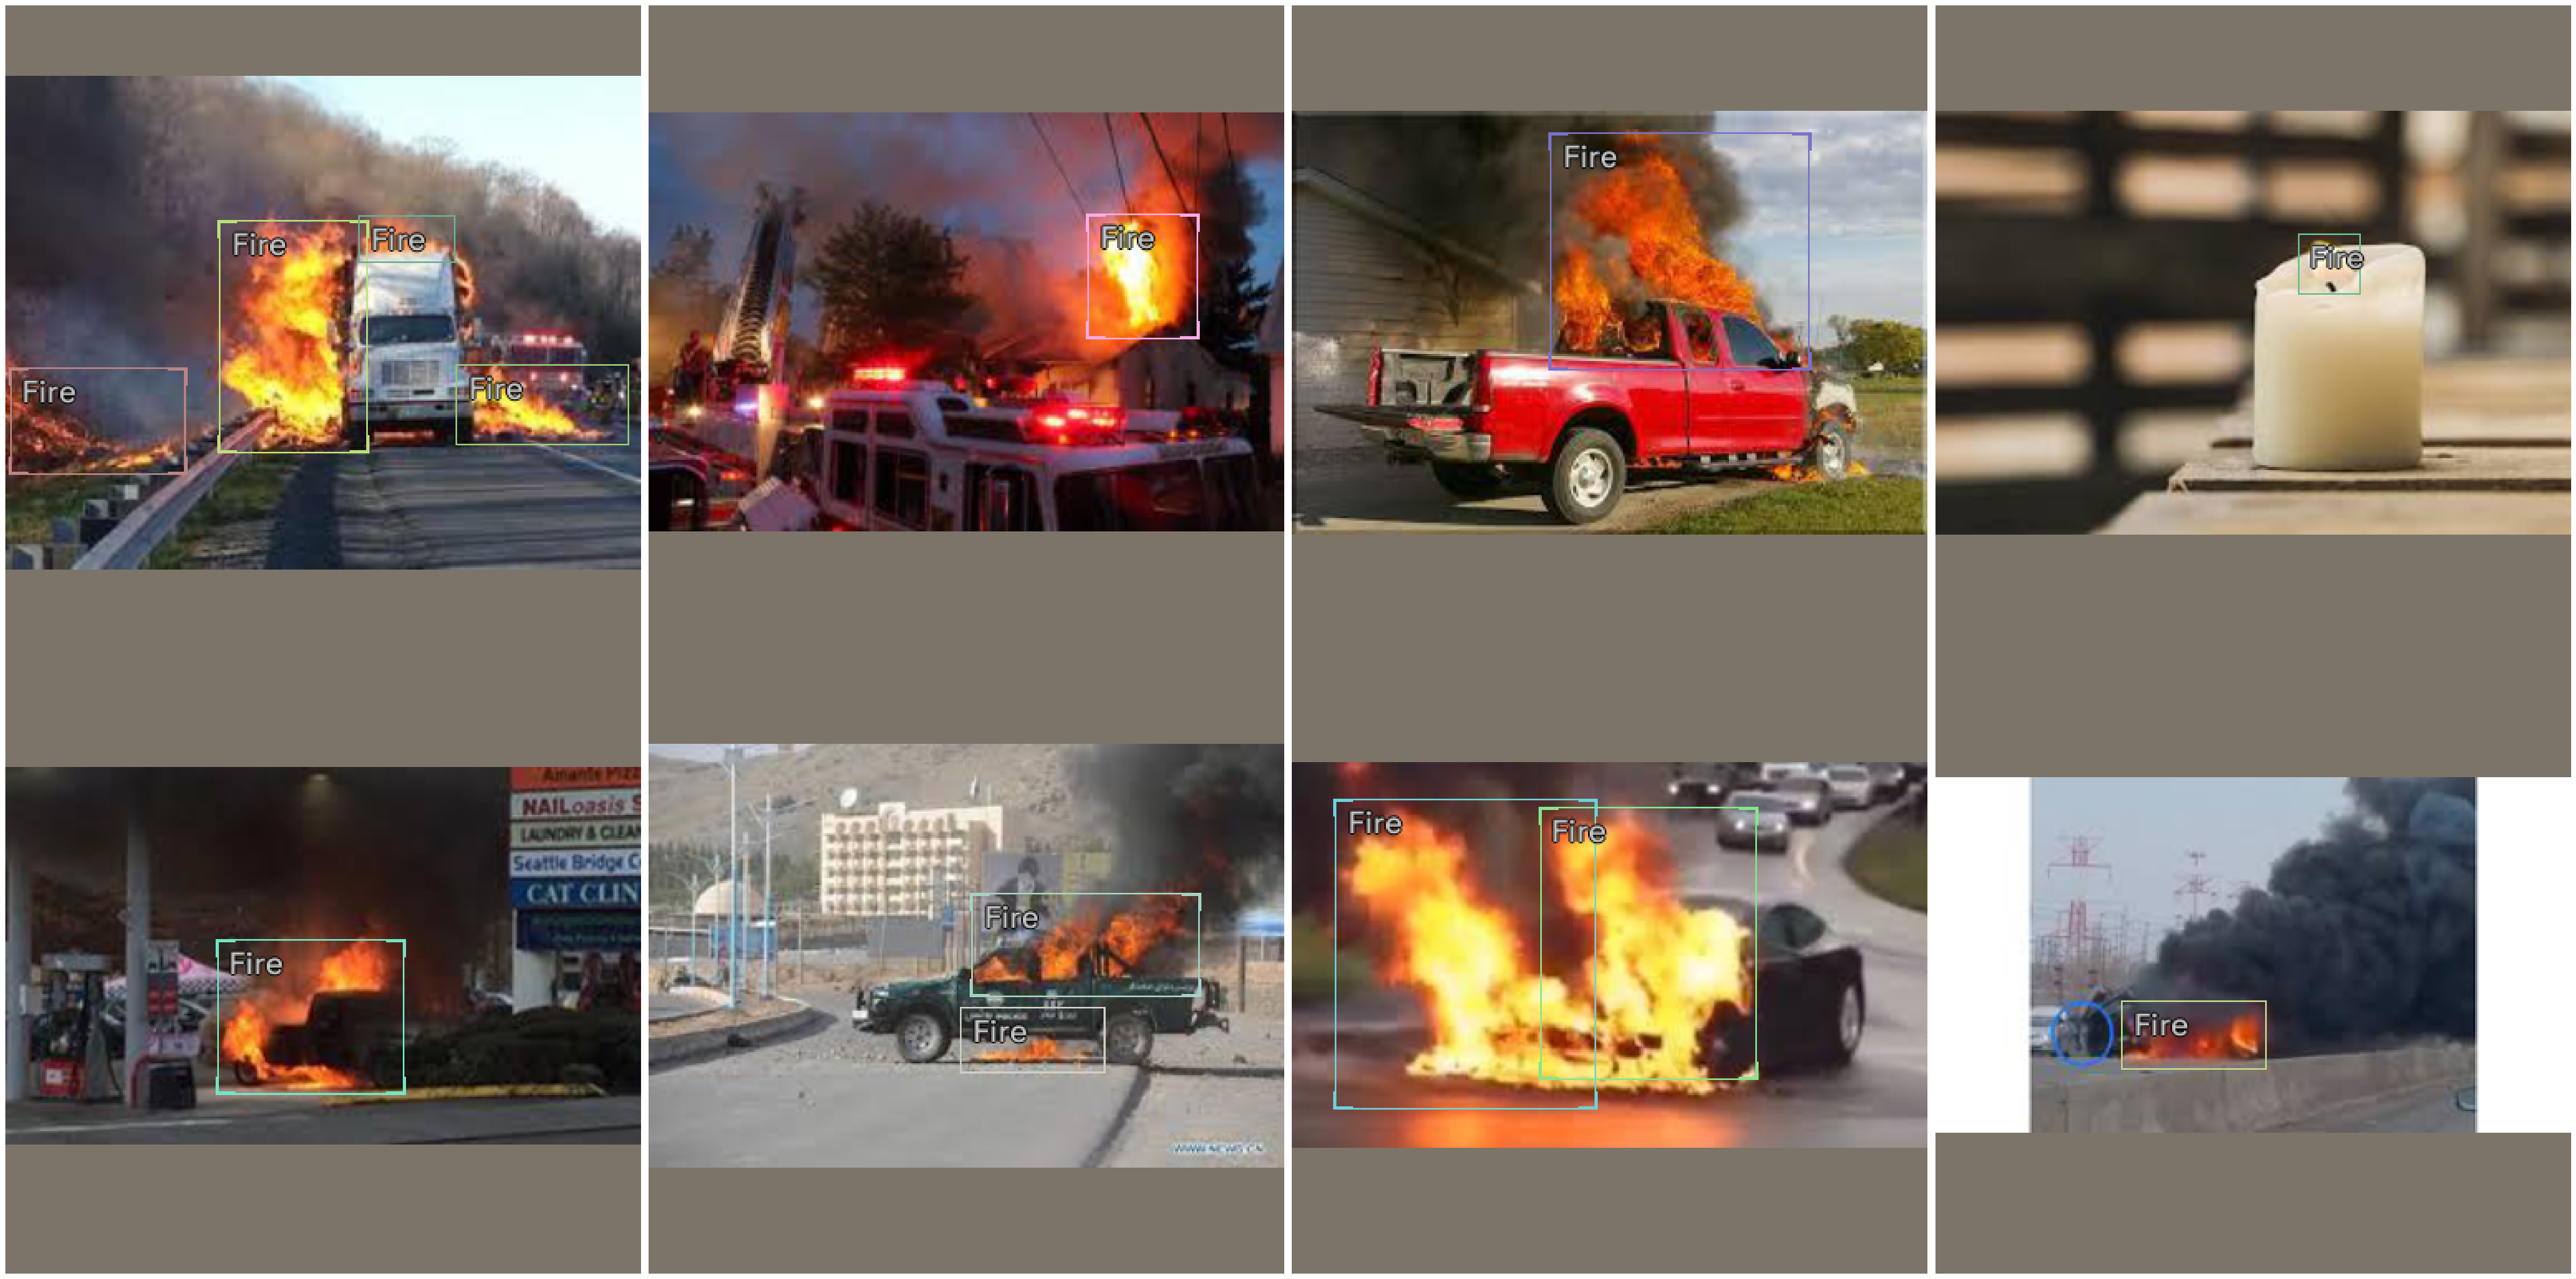

In [ ]:
# show batch
model_type.show_batch(first(valid_dl), ncols=4)

In [ ]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [ ]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

/usr/local/lib/python3.9/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.9/dist-packages/mmdet/core/anchor/anchor_generator.py:360: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  warnings.warn(


SuggestedLRs(valley=0.00013182566908653826)

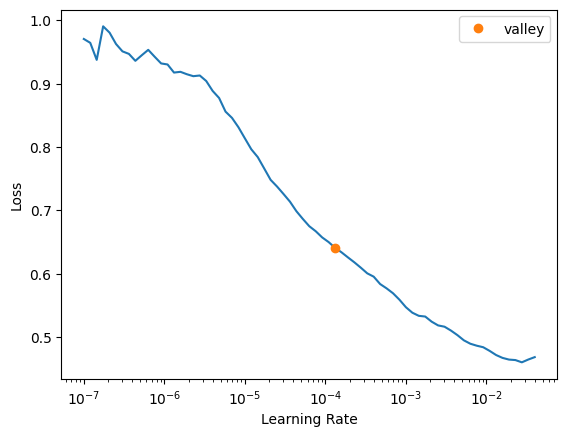

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(6, 8e-4, freeze_epochs=4)

/usr/local/lib/python3.9/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.9/dist-packages/mmdet/core/anchor/anchor_generator.py:360: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  warnings.warn(


/usr/local/lib/python3.9/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.9/dist-packages/mmdet/core/anchor/anchor_generator.py:360: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  warnings.warn(


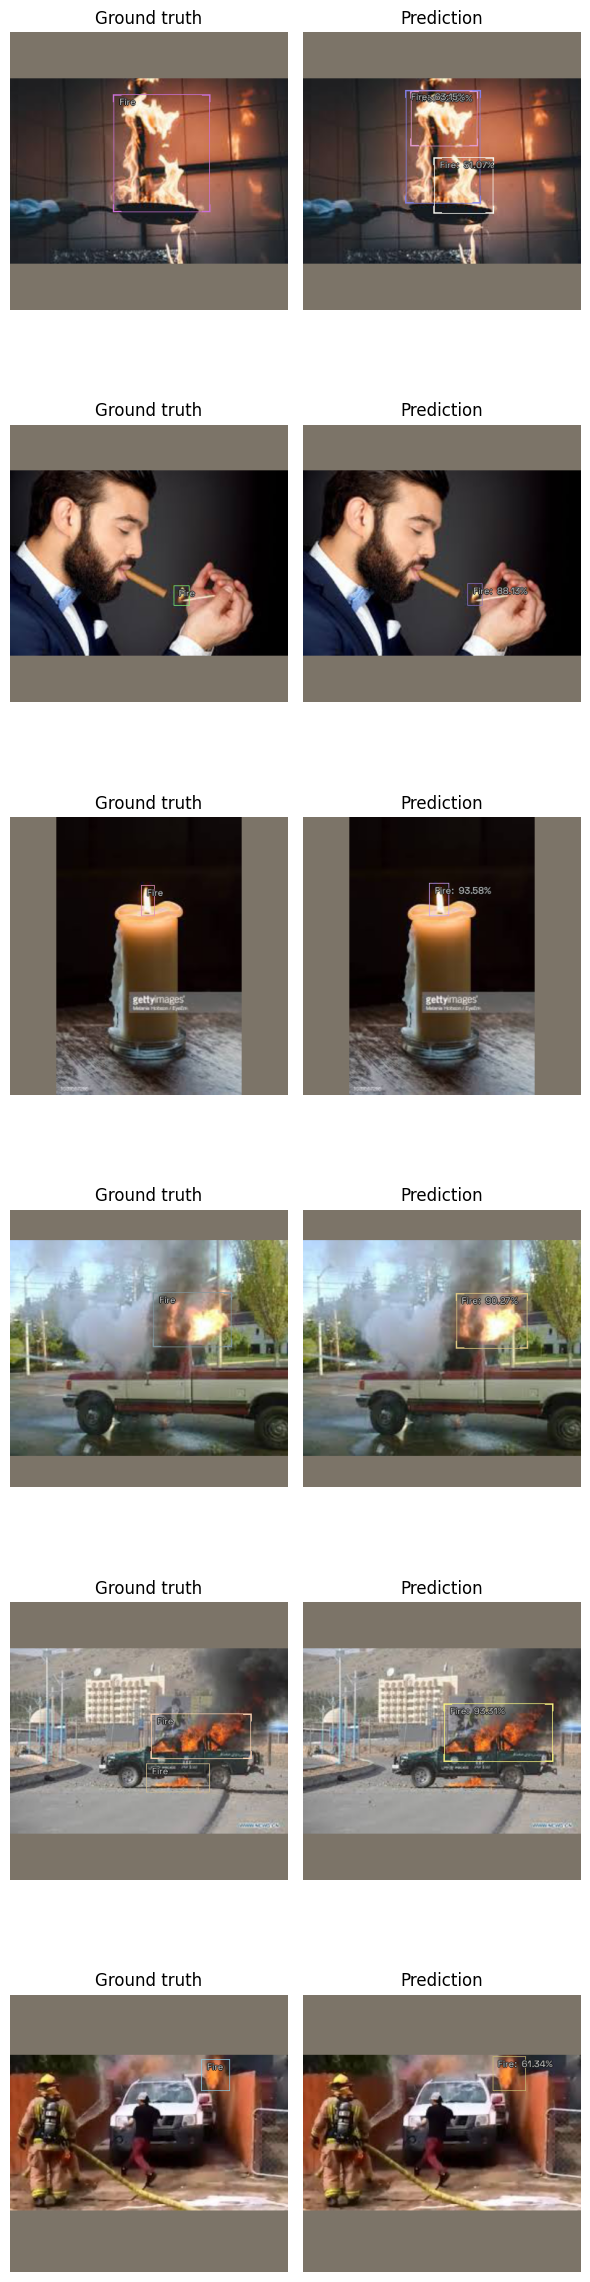

In [ ]:
model_type.show_results(model, valid_ds, detection_threshold=.5)

In [ ]:
from PIL import Image
img = Image.open('test.jpg') 
pred_dict  = model_type.end2end_detect(img, valid_tfms, model, class_map=parser.class_map, detection_threshold=0.5)

/usr/local/lib/python3.9/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.9/dist-packages/mmdet/core/anchor/anchor_generator.py:360: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  warnings.warn(


In [ ]:
# How to save a model and its metadata
checkpoint_path = str(config.MODEL_DIR / 'fire-fasterRcnn-checkpoint-full.pth')
save_icevision_checkpoint(model, 
                        model_name='mmdet.faster_rcnn', 
                        backbone_name='resnet101_fpn_2x',
                        classes =  parser.class_map.get_classes(), 
                        img_size=image_size, 
                        filename=checkpoint_path,
                        meta={'icevision_version': '0.9.1'})

In [ ]:
extra_args = {}
model_type = models.mmdet.deformable_detr
backbone = model_type.backbones.twostage_refine_r50_16x2_50e_coco

In [ ]:
# Instantiate the model
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map), **extra_args) 

/usr/local/lib/python3.9/dist-packages/mmcv/cnn/bricks/transformer.py:341: UserWarning: The arguments `feedforward_channels` in BaseTransformerLayer has been deprecated, now you should set `feedforward_channels` and other FFN related arguments to a dict named `ffn_cfgs`. 
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/mmcv/cnn/bricks/transformer.py:341: UserWarning: The arguments `ffn_dropout` in BaseTransformerLayer has been deprecated, now you should set `ffn_drop` and other FFN related arguments to a dict named `ffn_cfgs`. 
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/mmcv/cnn/bricks/transformer.py:341: UserWarning: The arguments `ffn_num_fcs` in BaseTransformerLayer has been deprecated, now you should set `num_fcs` and other FFN related arguments to a dict named `ffn_cfgs`. 
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/mmcv/cnn/bricks/transformer.py:92: UserWarning: The arguments `dropout` in MultiheadAttention has been deprecated, now you can separat

load checkpoint from local path: checkpoints/deformable_detr/deformable_detr_twostage_refine_r50_16x2_50e_coco_20210419_220613-9d28ab72.pth
The model and loaded state dict do not match exactly

size mismatch for bbox_head.cls_branches.0.weight: copying a param with shape torch.Size([80, 256]) from checkpoint, the shape in current model is torch.Size([1, 256]).
size mismatch for bbox_head.cls_branches.0.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([1]).
size mismatch for bbox_head.cls_branches.1.weight: copying a param with shape torch.Size([80, 256]) from checkpoint, the shape in current model is torch.Size([1, 256]).
size mismatch for bbox_head.cls_branches.1.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([1]).
size mismatch for bbox_head.cls_branches.2.weight: copying a param with shape torch.Size([80, 256]) from checkpoint, the shape in current model is torch.S

In [ ]:
# Data Loaders
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


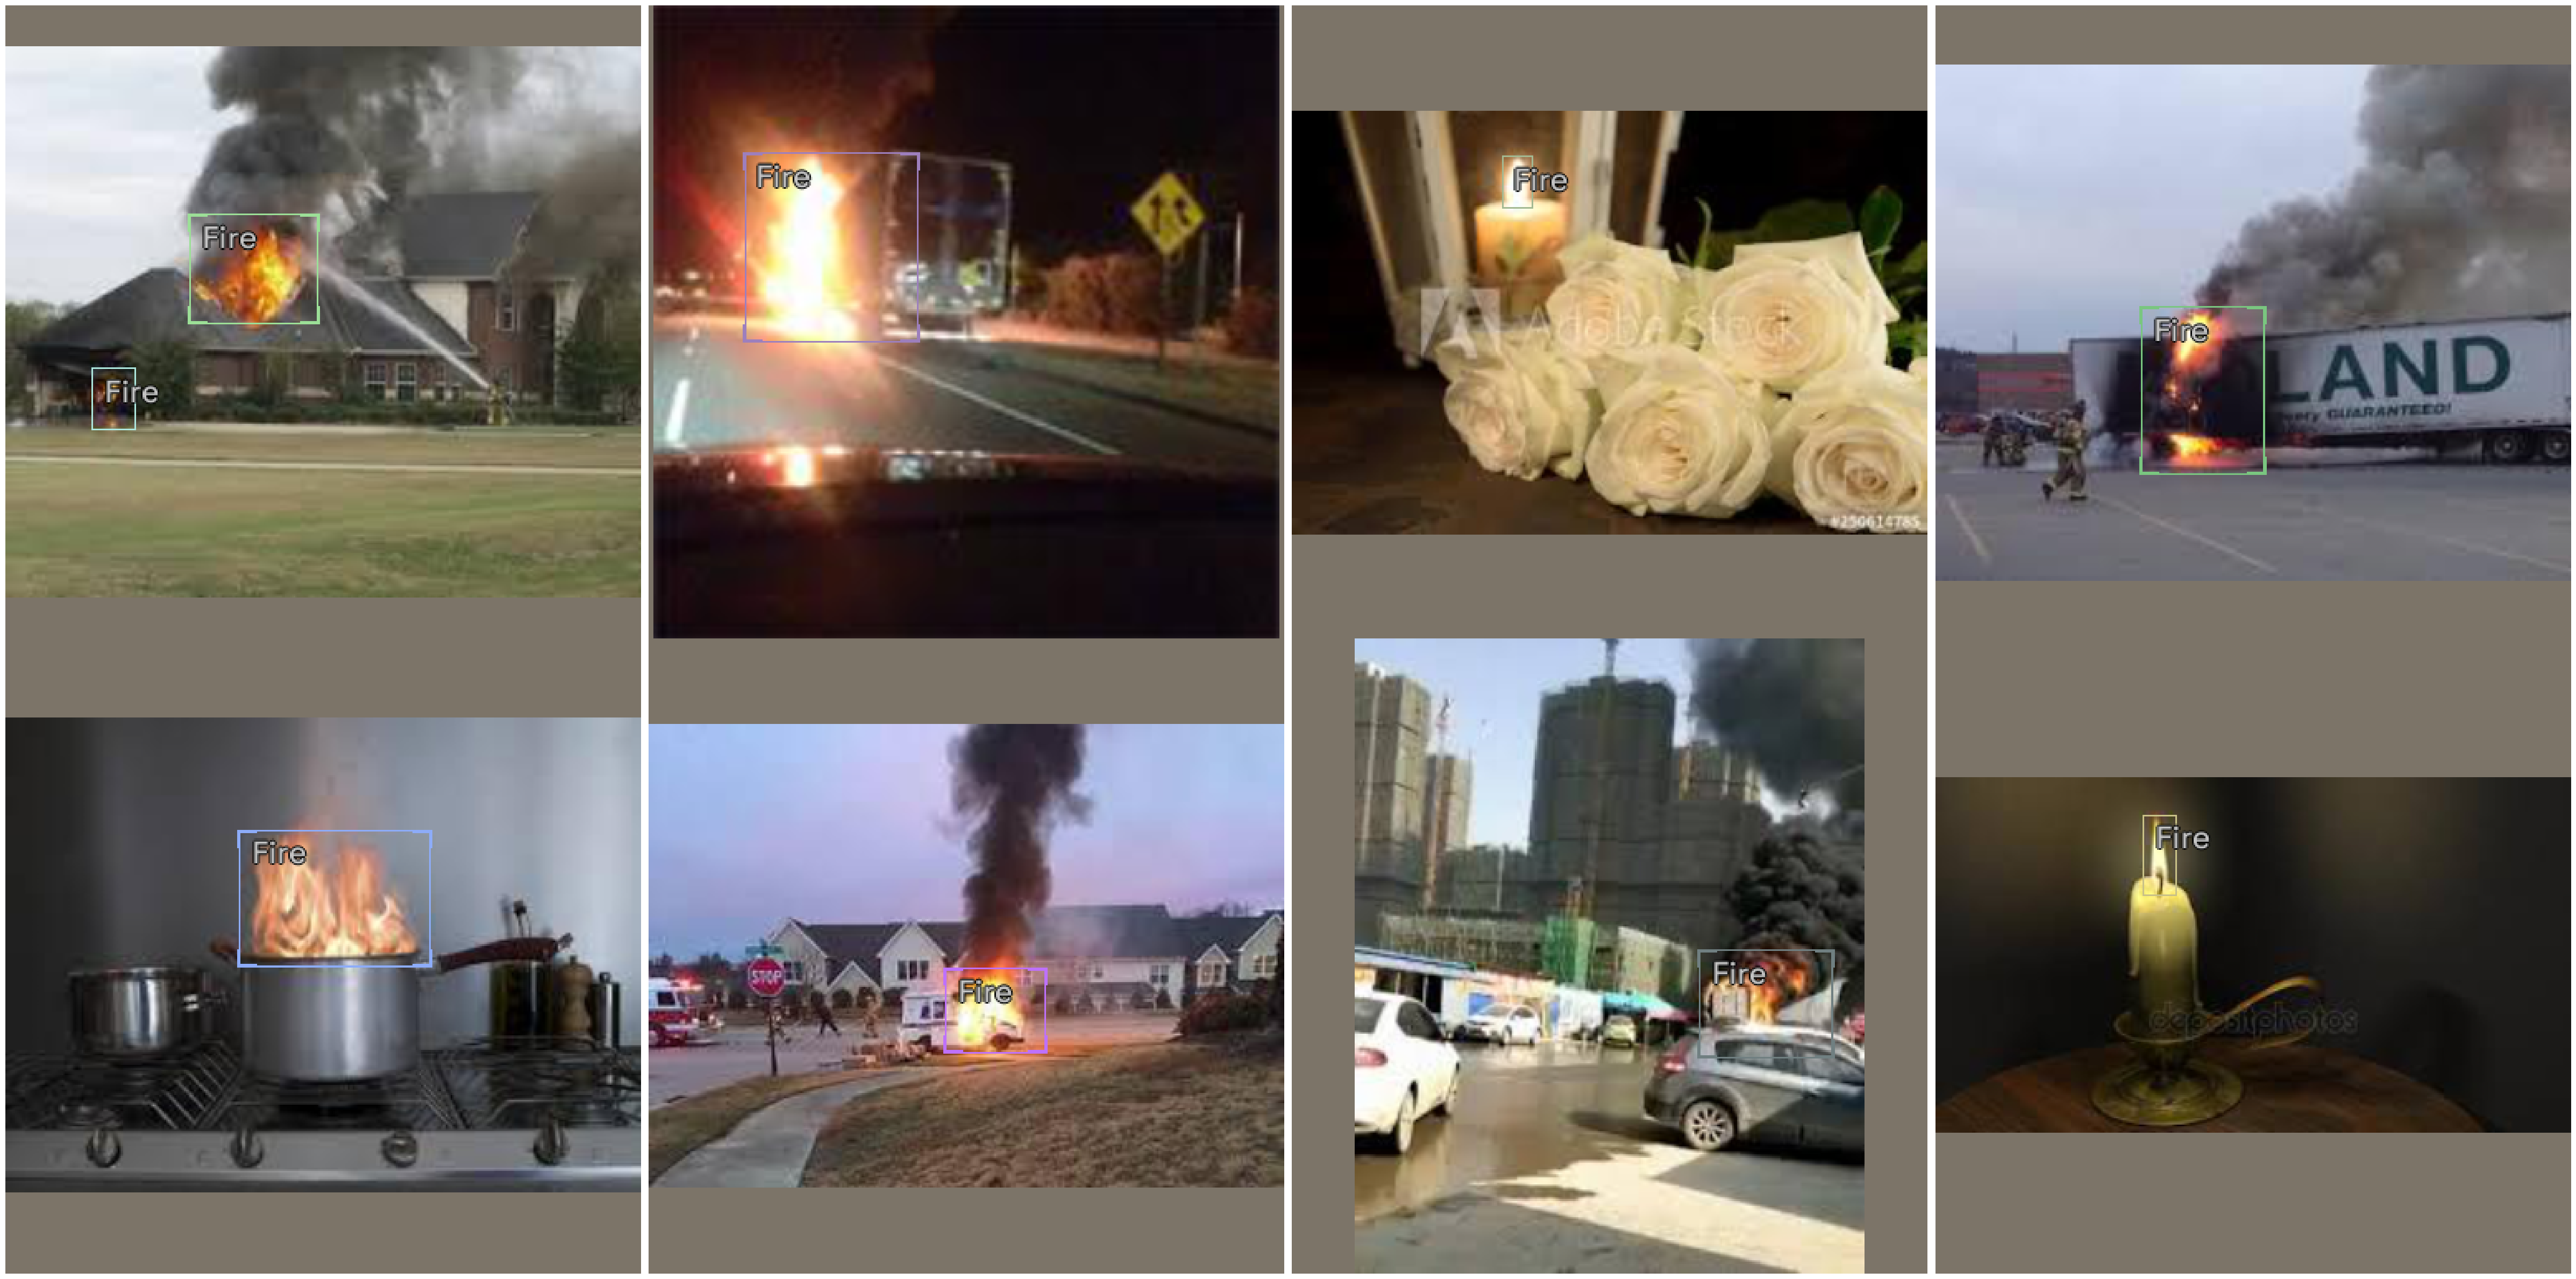

In [ ]:
# show batch
model_type.show_batch(first(valid_dl), ncols=4)

In [ ]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [ ]:
from fastai.vision.all import SaveModelCallback
cbs = SaveModelCallback('COCOMetric')

In [ ]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics, cbs=cbs)

/usr/local/lib/python3.9/dist-packages/mmdet/models/utils/positional_encoding.py:81: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature**(2 * (dim_t // 2) / self.num_feats)
/usr/local/lib/python3.9/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.9/dist-packages/mmdet/models/utils/transformer.py:883: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future ver

SuggestedLRs(valley=0.0006918309954926372)

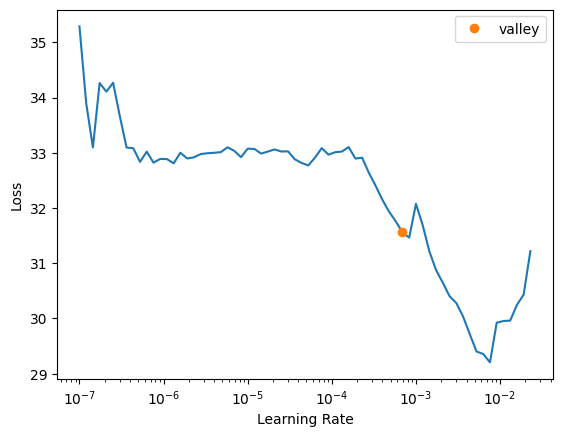

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(8, 6e-4, freeze_epochs=10)

/usr/local/lib/python3.9/dist-packages/mmdet/models/utils/positional_encoding.py:81: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature**(2 * (dim_t // 2) / self.num_feats)
/usr/local/lib/python3.9/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.9/dist-packages/mmdet/models/utils/transformer.py:883: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future ver

Better model found at epoch 0 with COCOMetric value: 0.0038750475373953716.
Better model found at epoch 1 with COCOMetric value: 0.03399498479756343.
Better model found at epoch 2 with COCOMetric value: 0.08076022044107091.
Better model found at epoch 3 with COCOMetric value: 0.09607268735182964.
Better model found at epoch 4 with COCOMetric value: 0.14091630194812843.
Better model found at epoch 7 with COCOMetric value: 0.1430528281160504.
Better model found at epoch 8 with COCOMetric value: 0.14709741291086909.
Better model found at epoch 9 with COCOMetric value: 0.18307674914877167.


Better model found at epoch 0 with COCOMetric value: 0.17911755427658838.
Better model found at epoch 1 with COCOMetric value: 0.23499961390231028.
Better model found at epoch 3 with COCOMetric value: 0.25185634662867784.
Better model found at epoch 4 with COCOMetric value: 0.30297842549273063.
Better model found at epoch 6 with COCOMetric value: 0.31226857766476535.


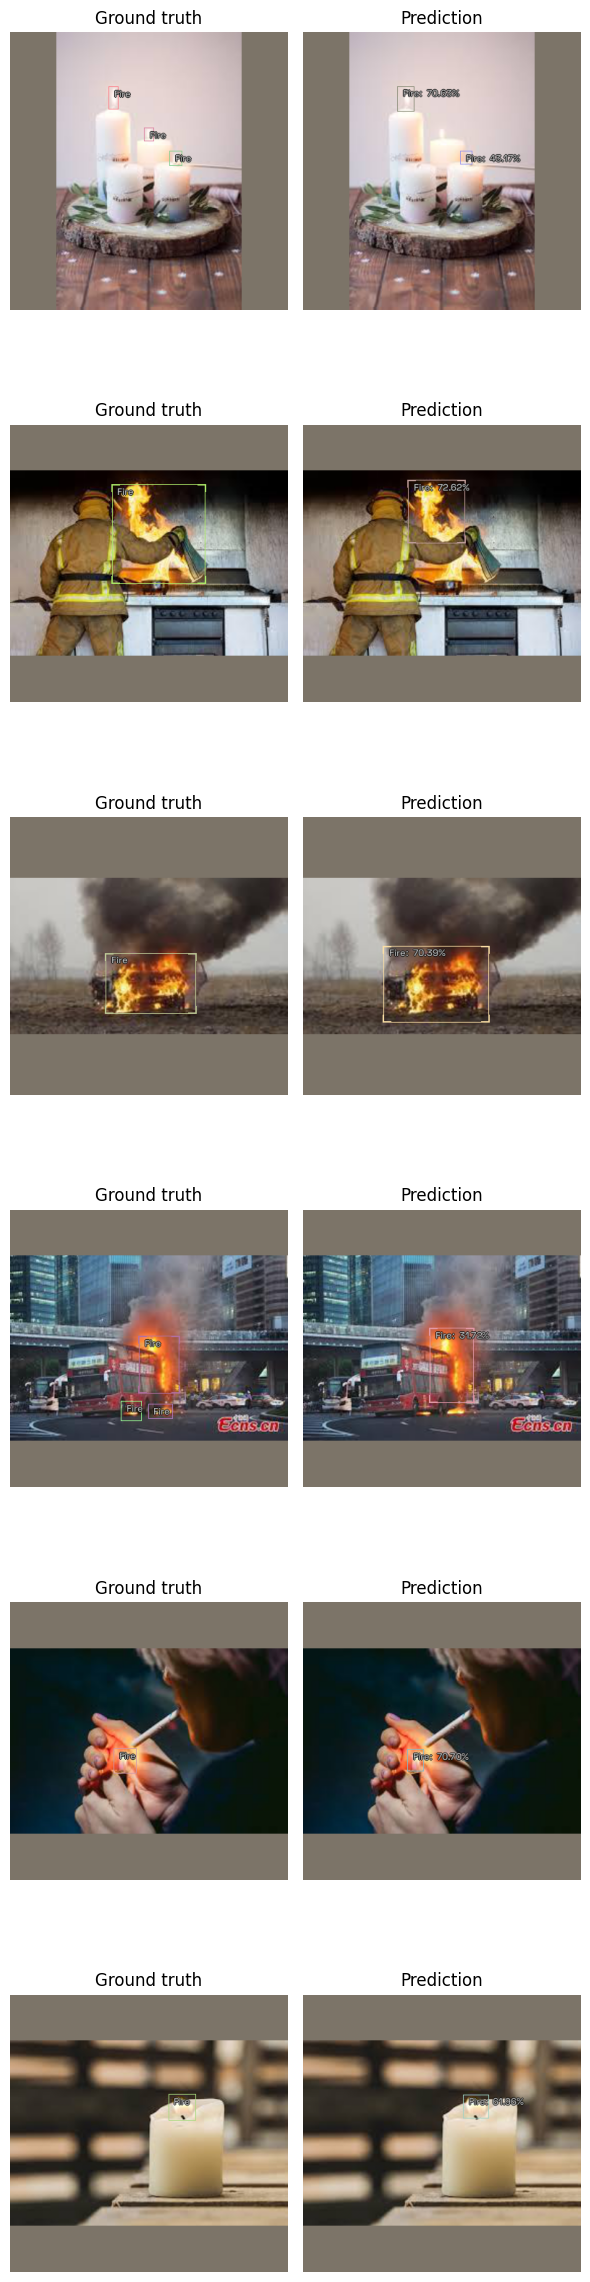

In [ ]:
model_type.show_results(model, valid_ds, detection_threshold=.3)

In [ ]:
from PIL import Image
img = Image.open('test.jpg') 
pred_dict  = model_type.end2end_detect(img, valid_tfms, model, class_map=parser.class_map, detection_threshold=0.5)

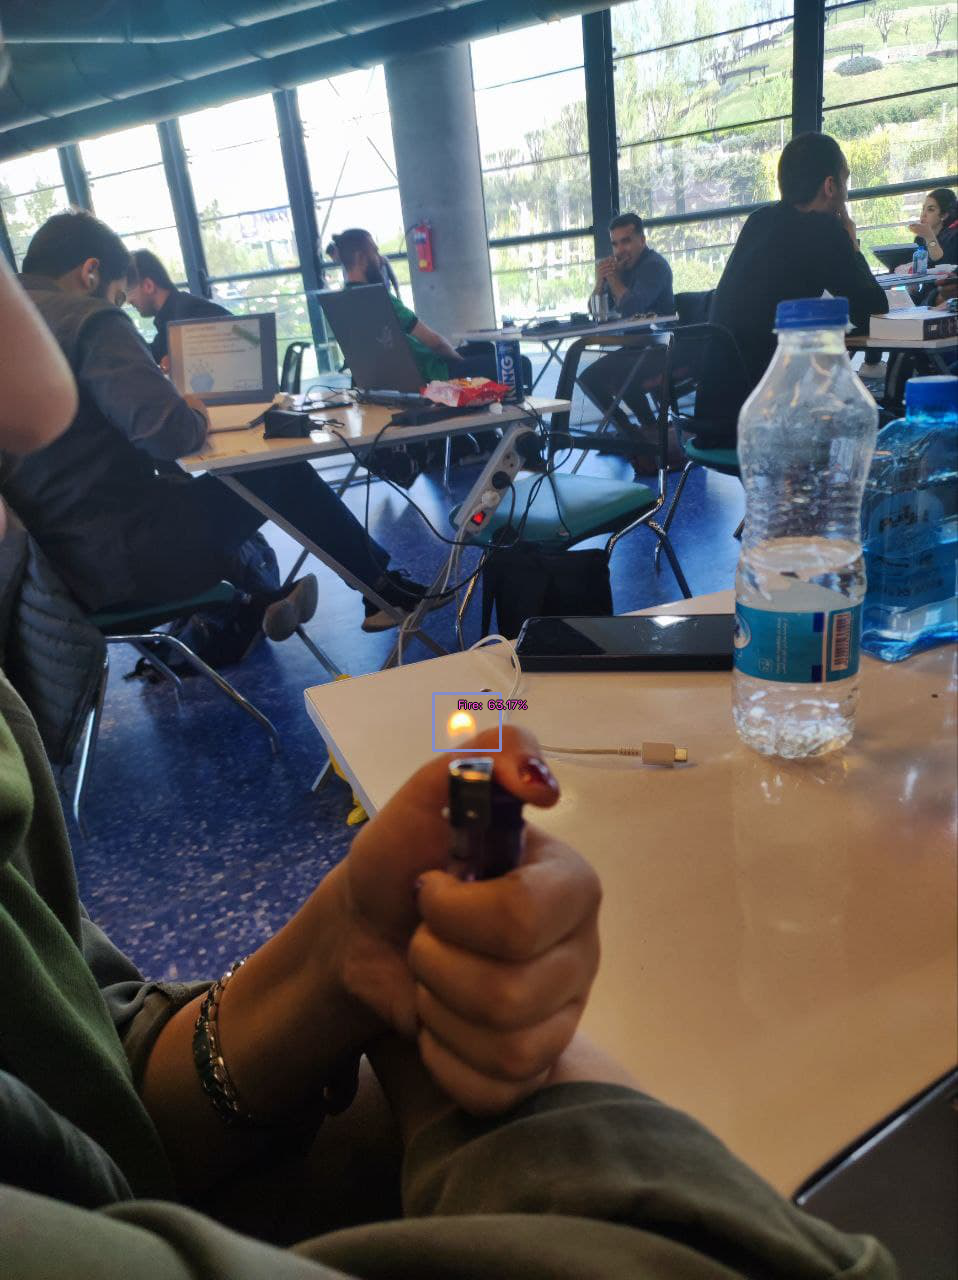

In [ ]:
pred_dict['img']

In [ ]:
# How to save a model and its metadata
checkpoint_path = str(config.MODEL_DIR / 'fire-detr-checkpoint-full.pth')
save_icevision_checkpoint(model, 
                        model_name='mmdet.deformable_detr', 
                        backbone_name='twostage_refine_r50_16x2_50e_coco',
                        classes =  parser.class_map.get_classes(), 
                        img_size=image_size, 
                        filename=checkpoint_path,
                        meta={'icevision_version': '0.9.1'})